# IoT Challenge - Geolocalization

In [2]:
%matplotlib inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from geopy.distance import vincenty
from plotly import offline
import folium
import datetime as dt
import seaborn as sns
sns.set(rc={'figure.figsize':(10,7.5)})


import warnings
warnings.filterwarnings('ignore')

from sklearn.model_selection import train_test_split, KFold
from sklearn.ensemble import RandomForestRegressor, ExtraTreesRegressor

In [4]:
# load train and test data
df_mess_train = pd.read_csv('mess_train_list.csv') # train set
df_mess_test = pd.read_csv('mess_test_list.csv') # test set
pos_train = pd.read_csv('pos_train_list.csv') # position associated to train set

## Data exploration

In [5]:
# DataFrame containing the GPS Coordinates of all the bases (train and test datasets)

base_pos = pd.concat([df_mess_test, df_mess_train])[["bsid", "bs_lat", "bs_lng"]].drop_duplicates()


# List of bases in the train set whose coordinates are (64.3, -68.5)

bases_wo_coordinates = np.unique(base_pos[base_pos["bs_lat"] == 64.3]["bsid"])


# List of unique messages with at least one reception from the base with 
# outlier coordinates (see later) | (64.3, -68.5)

msg_incl_bs_wo_coord = np.unique(df_mess_train[df_mess_train["bsid"].isin(bases_wo_coordinates)]["messid"])


# Train dataset containing only messages whose attached device sent at least one message to the base with
# outlier coordinates (see later) | (64.3, -68.5)

df_msg_incl_bs_wo_coord = df_mess_train[df_mess_train["messid"].isin(msg_incl_bs_wo_coord)]


# List of all bases in the above dataset : bases of reception for devices that sent at least one message
# to the base with outlier cooridnates (see later) | (64.3, -68.5)

base_pos_msg_sent_to_outlier_bases = df_msg_incl_bs_wo_coord[["bsid", "bs_lat", "bs_lng"]].drop_duplicates()

In [6]:
t0 = dt.datetime.now()

# Barycentre Coordinates
barycentre = [41.822374, -104.039671]

# Sample (0.33% over 1.5 million) 
sample_coords = base_pos[["bs_lat", "bs_lng"]].values

# Build map 
map_bases = folium.Map(location=barycentre, zoom_start=3.2, 
tiles='cartodbpositron', width=640, height=480)

# [ unicode(x.strip()) if x is not None else '' for x in row ]


# Plot coordinates using comprehension list
[folium.CircleMarker(sample_coords[i], radius=1,
                color='red', fill_color='red').add_to(map_bases)
 if np.array_equal(sample_coords[i], [64.3, -68.5])
 else folium.CircleMarker(sample_coords[i], radius=1,
                color='#0080bb', fill_color='#0080bb').add_to(map_bases)
 for i in range(len(sample_coords))]

# Display map in Jupyter
display(map_bases)

===================================================================================================================

Bases are located around Denver in the US. The map allows to identify potential outliers, particularly in the North-East of Canada (GPS Coordinates : 64.3, -68.5)

===================================================================================================================

In [8]:
tmp = df_msg_incl_bs_wo_coord.join(pos_train)
tmp = tmp[["lat", "lng"]]
tmp.drop_duplicates(inplace=True)

t0 = dt.datetime.now()

# Barycentre Coordinates
barycentre = [39.823794, -105.099671]

# Sample (0.33% over 1.5 million) 
sample_coords = tmp.values

# Build map 
map_bases = folium.Map(location=barycentre, zoom_start=9.2, 
tiles='cartodbpositron', width=640, height=480)

# Plot coordinates using comprehension list
[folium.CircleMarker(sample_coords[i], radius=1,
                color='#71ddc0', fill_color='#71ddc0').add_to(map_bases)
 for i in range(len(sample_coords))]

sample_coords = base_pos_msg_sent_to_outlier_bases[["bs_lat", "bs_lng"]].values

# Build map 
[folium.CircleMarker(sample_coords[i], radius=1,
                color='red', fill_color='red').add_to(map_bases)
 if np.array_equal(sample_coords[i], [64.3, -68.5])
 else folium.CircleMarker(sample_coords[i], radius=1,
                color='#0080bb', fill_color='#0080bb').add_to(map_bases)
 for i in range(len(sample_coords))]



# Display map in Jupyter
display(map_bases)

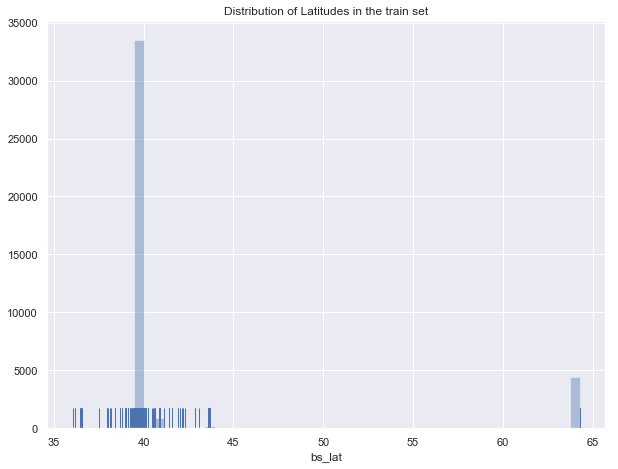

In [9]:
sns.distplot(df_mess_train["bs_lat"], kde=False, rug=True)
plt.title("Distribution of Latitudes in the train set")
plt.show()

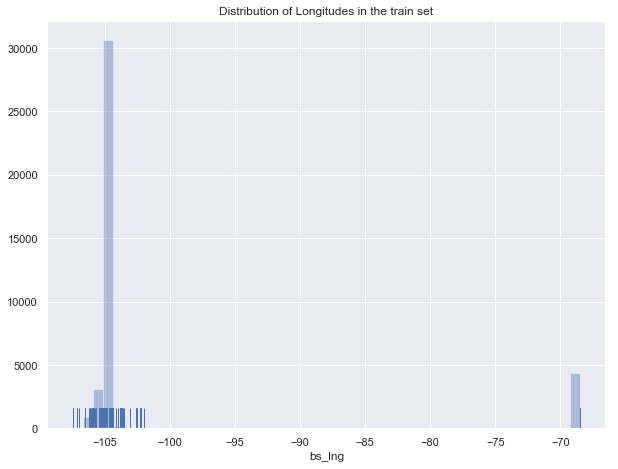

In [10]:
sns.distplot(df_mess_train["bs_lng"], kde=False, rug=True)
plt.title("Distribution of Longitudes in the train set")
plt.show()

In [11]:
df_msg_per_base_train = df_mess_train.groupby(["bs_lat", "bs_lng"]).count().sort_values("bsid", ascending=False).reset_index()[["bs_lat", "bs_lng", "messid"]]
df_msg_per_base_train.columns = ["bs_lat", "bs_lng", "nb_msgs"]
df_msg_per_base_test = df_mess_test.groupby(["bs_lat", "bs_lng"]).count().sort_values("bsid", ascending=False).reset_index()[["bs_lat", "bs_lng", "messid"]]
df_msg_per_base_test.columns = ["bs_lat", "bs_lng", "nb_msgs"]

df_msg_per_base_train.head()

,bs_lat,bs_lng,nb_msgs
0,64.300000,-68.500000,4389
1,39.803795,-105.072090,1128
2,39.817654,-105.050984,1073
3,39.704887,-105.016392,987
4,39.805696,-105.056208,888


In [12]:
print("TRAIN SET | Share of messages sent to base with odd coordinates: {:0.2%}".format(df_msg_per_base_train["nb_msgs"][0] / df_msg_per_base_train.sum()["nb_msgs"]))
print("-----------------------------------------------------------------")

print("TEST SET | Share of messages sent to base with odd coordinates: {:0.2%}".format(df_msg_per_base_test["nb_msgs"][0] / df_msg_per_base_test.sum()["nb_msgs"]))
print("-----------------------------------------------------------------")
print("Number of bases with 'outlier' coordinates: " + str(bases_wo_coordinates.shape[0]))

TRAIN SET | Share of messages sent to base with odd coordinates: 11.18%
-----------------------------------------------------------------
TEST SET | Share of messages sent to base with odd coordinates: 10.48%
-----------------------------------------------------------------
Number of bases with 'outlier' coordinates: 29


In [13]:
def base_categorization(row):
    return (row["bs_lat"] == 64.3) * 1

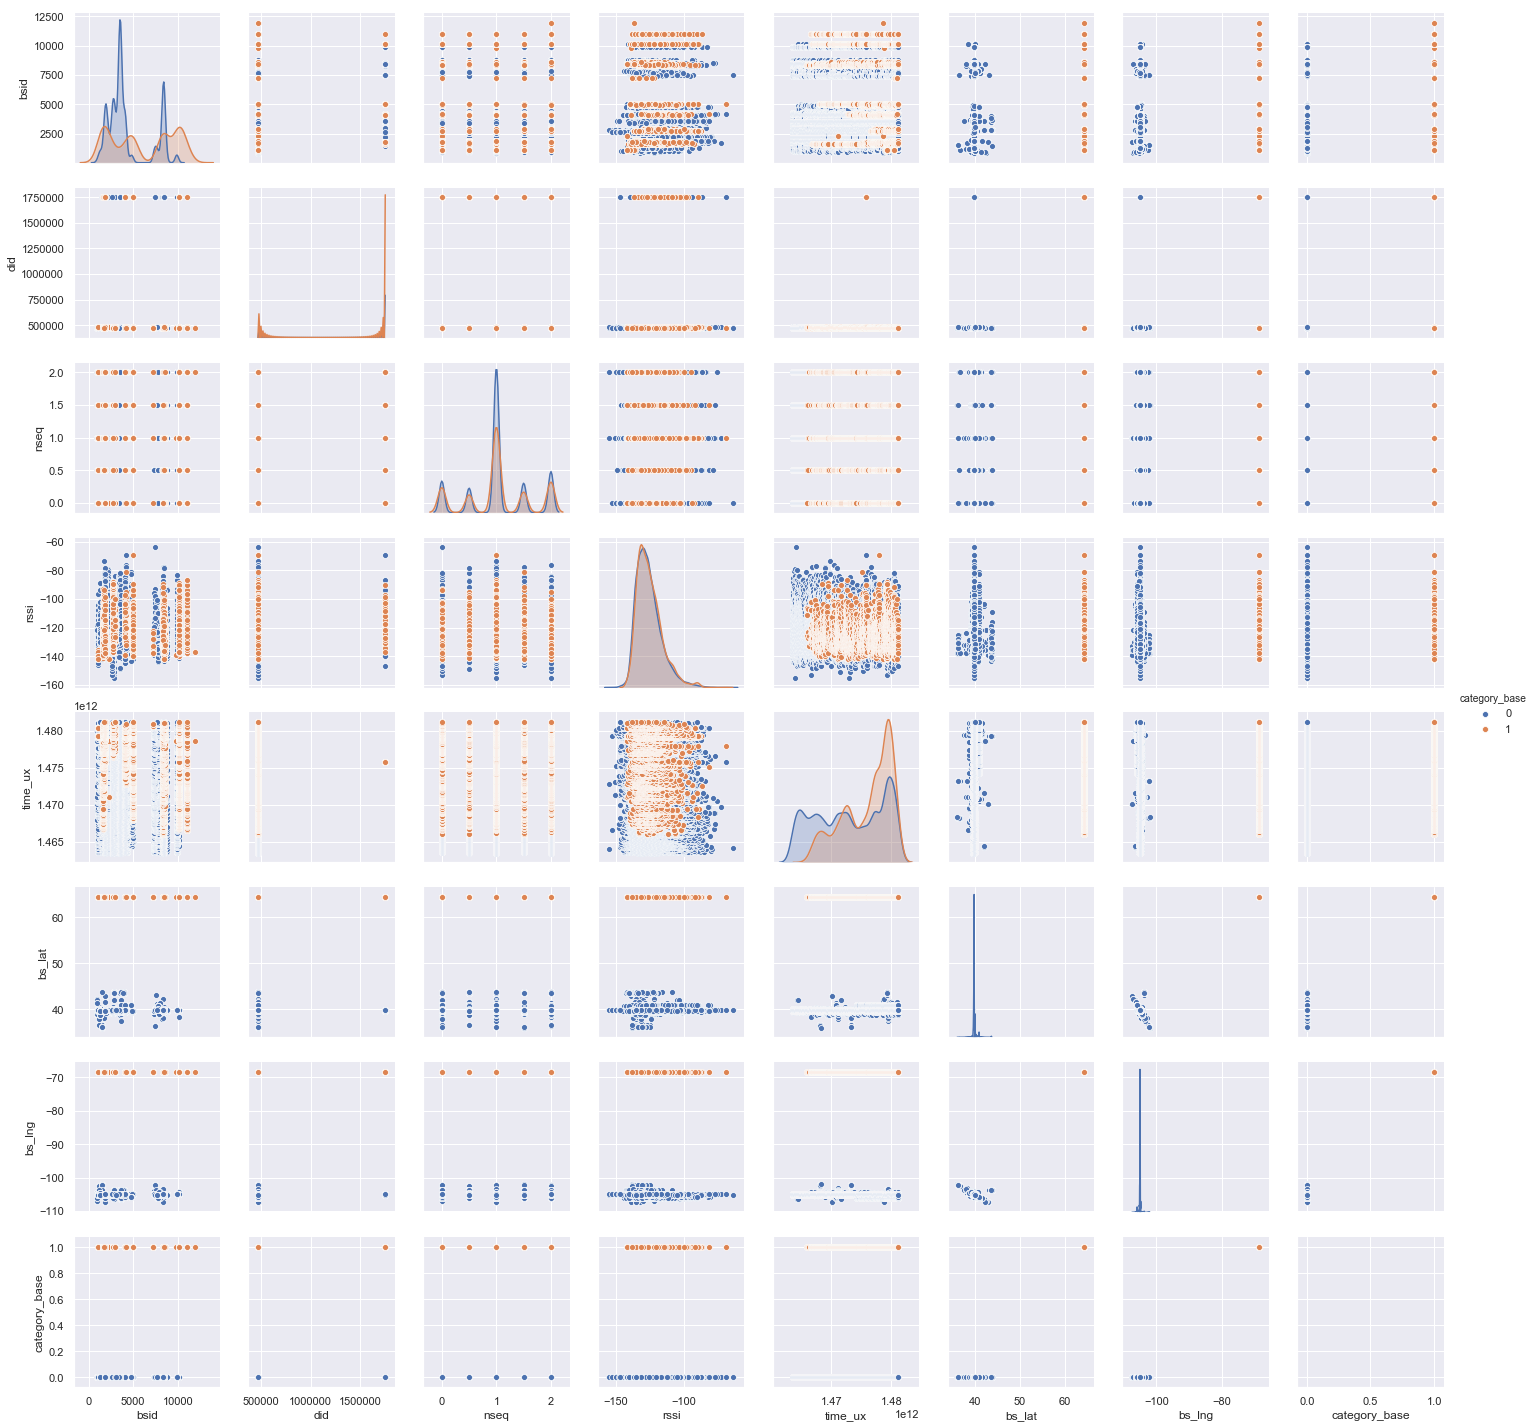

In [15]:
df_mess_train["category_base"] = df_mess_train.apply(base_categorization, axis=1)

sns.pairplot(df_mess_train, hue="category_base")
plt.show()

===================================================================================================================

Bases located at (GPS Coordinates : 64.3, -68.5) represent a signficiant share of data points : ~10% on the whole dataset. Analysing the pairplot graph above shows no differences in data (including rssi) apart from the GPS location, confirming a recording error

===================================================================================================================

## Outliers processing I [André]

Following our realization of outlier bases with geolocalization positions that do not seem to make sense, we decided to compute, approximatelly, their longitude and latitude by using the coordinates of the (weighted) barycentre of the messages each outlier base received.

The code coded provided below did this cleaning

In [5]:
# List of unique messages
listOfmess = np.unique(df_mess_train['messid'])

# DataFrame with all training_data, including positions
df = pd.concat([df_mess_train, pos_train], axis=1)

In [19]:
# We can notice that the outlier bases have latitude at 64.3 and longitude at -68.5:
df.groupby(['bsid']).mean()[['bs_lat', 'bs_lng']].sort_values(['bs_lat'], ascending=False).head(10)

,bs_lat,bs_lng
bsid,,
1772,64.3,-68.5
4156,64.3,-68.5
8560,64.3,-68.5
2943,64.3,-68.5
8449,64.3,-68.5
4987,64.3,-68.5
11951,64.3,-68.5
2293,64.3,-68.5
7248,64.3,-68.5


In [45]:
# Selecting these bases
bases_out = df[(df['bs_lat']==64.3) & (df['bs_lng']==-68.5)]['bsid'].unique()
bases_out

array([ 8355, 11007,  1594, 10151, 10162,  8451,  4993,  8560,  2293,
        4959, 10999,  1661,  8449,  4156,  4129,  1743,  4987,  1772,
        1796,  2707,  2943,  4123, 11951,  9784,  1092,  1854,  7248])

In [70]:
# Getting dataframe with all data for the ouliers bases
df_out = df[df['bsid'].isin(bases_out)]

# Initiating arrays that will have the lat, long and rssi of messages received by the bases, 
# Each column represents a message
mess_num = len(listOfmess) # number of messages
lat_array = np.zeros((df_out.shape[0], mess_num))
lng_array = np.zeros((df_out.shape[0], mess_num))
weight_array = np.zeros((df_out.shape[0], mess_num)) # weights to be used: sqrt(exp(rssi))
    
# Dictionary to track message id and corresponding column in array
mess_dict = {}
for i, column in enumerate(listOfmess):
    mess_dict[column] = i
    
# assigning values to arrays
for i, ix in enumerate(df_out.index):
    mess = df_out.loc[ix, 'messid']
    column = mess_dict[mess]
    
    # Using sqrt(exp(rssi)) as weight to get weighted centroid
    weight_array[i, column] = np.sqrt(np.exp(df_out.loc[ix, 'rssi']))
    weight = np.sqrt(np.exp(df_out.loc[ix, 'rssi']))
    lat_array[i, column] = df_out.loc[ix, 'lat'] * weight
    lng_array[i, column] = df_out.loc[ix, 'lng'] * weight
    
# Transforming arrays in dataframe in order to use groupby()
lat_df = pd.DataFrame(lat_array)
lng_df = pd.DataFrame(lng_array)
weight_df = pd.DataFrame(weight_array)

# Adding column bsid for each dataframes in order to perform groupby()
lat_df['bsid'] = lng_df['bsid'] = weight_df['bsid'] = df_out.reset_index()['bsid']

# Grouping and suming --- Note that values for lat and lng are already weighted
lat_df_grouped = lat_df.groupby('bsid').sum()
lng_df_grouped = lng_df.groupby('bsid').sum()
weight_df_grouped = weight_df.groupby('bsid').sum()

# Dividing each row by the sum of the weights for the respective row
lat_df_grouped = lat_df_grouped.divide(weight_df_grouped.sum(axis=1), axis=0)
lng_df_grouped = lng_df_grouped.divide(weight_df_grouped.sum(axis=1), axis=0)

# Getting the final weighted latitudes and longitudes
lat_out = lat_df_grouped.sum(axis=1)
lng_out = lng_df_grouped.sum(axis=1)

# Assigning these new latitudes and longitudes to the bases in the test and training sets
for base in lat_out.index:
    df_mess_train.loc[df_mess_train['bsid']==base, 'bs_lat'] = lat_out.loc[base]
    df_mess_train.loc[df_mess_train['bsid']==base, 'bs_lng'] = lng_out.loc[base]
    
    df_mess_test.loc[df_mess_test['bsid']==base, 'bs_lat'] = lat_out.loc[base]
    df_mess_test.loc[df_mess_test['bsid']==base, 'bs_lng'] = lng_out.loc[base]

## Features Engineering [Mathieu]

### One-Hot (Teacher ++ / Mean / RSSI / etc.. )

### Usage of barycentre

#### Standard barycentre

#### Weighted barycentre

## Model [Mathieu / Matyas / André]

### First raw predictions

### Outliers processing II

### Fine-tunning / Model selection

### Blending

In [3]:
## Test pull request

## Testset preprocessing [André] 

We can notice that the test set has some of the outliers bases that are not present in the training set:

In [93]:
out_bases_test = df_mess_test[(df_mess_test['bs_lat']==64.3) & (df_mess_test['bs_lng']==-68.5)]['bsid'].unique()
out_bases_test

array([9949, 9941])

We can not replace their positions as we do not have the coordinates of the messages in the test set. Therefore, we decided to not include these two bases when computing the features (weighted barycentre) of the messages.

There is however one of these two bases, base 9949, that detect two messages which are only detected by that base:

In [91]:
# Getting the messages detected by the base 9949
messages_9949 = df_mess_test[df_mess_test.bsid == 9949].messid.values
messages_9949

array(['57b99c16cf554f465ad8de48', '57b9eff912f1434591626c19'],
      dtype=object)

In [92]:
# Display all rows with both messages
df_mess_test[df_mess_test.messid.isin(messages_9949)]

,messid,bsid,did,nseq,rssi,time_ux,bs_lat,bs_lng
13431,57b99c16cf554f465ad8de48,9949,472066.0,2.0,-122.000000,1.471782e+12,64.3,-68.5
13434,57b9eff912f1434591626c19,9949,472066.0,1.0,-118.666667,1.471803e+12,64.3,-68.5


We can see that this does not happen with the base 9941 as each of the three messages it detects is detected by the base 9941:

In [94]:
messages_9941 = df_mess_test[df_mess_test.bsid == 9941].messid.values
df_mess_test[df_mess_test.messid.isin(messages_9941)]

,messid,bsid,did,nseq,rssi,time_ux,bs_lat,bs_lng
14667,57cbf92412f1437531983238,9936,472066.0,1.0,-118.333333,1.472985e+12,48.072889,-110.957181
14668,57cbf92412f1437531983238,9941,472066.0,1.0,-123.500000,1.472985e+12,64.300000,-68.500000
14669,57cbfbbfcf554f22dc736cb2,9936,472066.0,1.0,-111.333333,1.472986e+12,48.072889,-110.957181
14670,57cbfbbfcf554f22dc736cb2,9941,472066.0,1.0,-124.666667,1.472986e+12,64.300000,-68.500000
28670,5843e9a6cf554f422f2b7495,9936,472066.0,1.0,-127.500000,1.480846e+12,48.072889,-110.957181
28671,5843e9a6cf554f422f2b7495,9941,472066.0,2.0,-135.000000,1.480846e+12,64.300000,-68.500000


AS both messages detected by the base 9949 are from the same device (did == 472066.0) we decided to predict their position as the mean position of the predictions of other detected messages from the same device. 

### Processing test set for the same structure as training set

In [96]:
# List of bases for test, excluding bases 9949, 9941
listOfBs_test = np.setdiff1d(
                    np.union1d(np.unique(df_mess_train['bsid']), np.unique(df_mess_test['bsid'])),
                    out_bases_test
                )

In [112]:
# Feature Matrix construction for test
# There is a try / except cell to handle keyError with bsids 9949 and 9941

def feat_mat_const_test(df_mess_test, listOfBs):
    ''' 
    Method used for creation of features. It uses numpy for calculations due to optimization issues
    
    Parameters
    ----------
    df_mess_test: raw test dataFrame with input data
    listOfBs: list of unique bases present in both train and test sets
    
    Returns
    -------
    df_feat: modified dataFrame with created features: longitude and latitude of the (weighted) 
    barycentre of the bases that detected each message
    '''
    
    bases_num = len(listOfBs)
    
    # Dictionnary that will track the column in the numpy array and its correpondent base 
    bases_dict = {}
    for i, column in enumerate(listOfBs):
        bases_dict[column] = i
    
    # Creating array to be transformed at feature matrix (columns = features)
    lat_array = np.zeros((df_mess_test.shape[0], bases_num))
    lng_array = np.zeros((df_mess_test.shape[0], bases_num))
    weights_array = np.zeros((df_mess_test.shape[0], bases_num))
    
    # assigning values for new features
    for i in df_mess_test.index:
        try: 
            # getting bsid for current row
            bsid = df_mess_test.loc[i, 'bsid']
            # getting colum to assign value in bases_array
            column = bases_dict[bsid]
            # assigning weight (sqrt(rssi)) value to cell in bases array
            weight = np.exp(df_mess_test.loc[i, 'rssi'])**(1/2)
            lat_array[i, column] = weight * df_mess_test.loc[i, 'bs_lat']
            lng_array[i, column] = weight * df_mess_test.loc[i, 'bs_lng']
            weights_array[i, column] = weight
        
        # To handle when we get a key error when bsid is equal to 9941 or 9949
        except KeyError: 
            pass
    
    # Tranforming bases_array to dataFrame in order to use .groupby()

    lat_df = pd.DataFrame(lat_array)
    lng_df = pd.DataFrame(lng_array)
    weights_df = pd.DataFrame(weights_array)
    
    
    # Using groupby() and getting final dataFrame of features
    
    # Adding messid column to each data-frame (lat, lng and weights)
    lat_df['messid'] = df_mess_test['messid']
    lng_df['messid'] = df_mess_test['messid']
    weights_df['messid'] = df_mess_test['messid']
    
    lat = lat_df.groupby('messid').sum().sum(axis=1)
    lng = lng_df.groupby('messid').sum().sum(axis=1)
    weights = weights_df.groupby('messid').sum().sum(axis=1)
    
    # Normalizing
    df_feat = pd.DataFrame([lat, lng], index=['lat','lng'])
    df_feat = (df_feat/weights).T
    
    return df_feat

In [106]:
# Creating dataframe of features for the test set
df_test = feat_mat_const_barycentre(df_mess_test, listOfBs_test)

In [107]:
df_test.head()

,lat,lng
messid,,
573be2503e952e191262c351,39.728651,-105.163032
573c05f83e952e1912758013,39.783207,-105.088708
573c0796f0fe6e735a66deb3,39.655285,-105.043437
573c08d2864fce1a9a0563bc,39.782113,-105.072701
573c08ff864fce1a9a0579b0,39.655282,-105.043385


In [110]:
# Checking for the messages detected by base 9949 (predictions to be replaced)
df_test.loc[messages_9949]

,lat,lng
messid,,
57b99c16cf554f465ad8de48,NaN,NaN
57b9eff912f1434591626c19,NaN,NaN


In [111]:
# Checking for the messages detected by base 9941 (these will not be replaced)
df_test.loc[messages_9941]

,lat,lng
messid,,
57cbf92412f1437531983238,48.072889,-110.957181
57cbfbbfcf554f22dc736cb2,48.072889,-110.957181
5843e9a6cf554f422f2b7495,48.072889,-110.957181


## Running final model and computing predictions on test set [André] 